In [1]:
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import neurokit2 as nk
from heartkit.defines import HeartTask
from heartkit.datasets.icentia11k import IcentiaDataset
from heartkit.datasets.ludb import LudbDataset
from heartkit.datasets.synthetic.rhythm_generator import nsr as syn_nsr, af as syn_af

physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass


In [9]:
def plot_segmentations(data, labels, preds):
    color_map = {0: 'gray', 1: 'blue', 2: 'red', 3: 'green'}

    t = np.arange(0, data.shape[0])
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(t, data)
    if preds is not None:
        pred_bnds = np.where(np.abs(np.diff(preds)) > 0)[0]
        pred_bnds = np.concatenate(([0], pred_bnds, [len(preds)-1]))
        for i in range(pred_bnds.shape[0]-1):   
            c = color_map.get(preds[pred_bnds[i]+1], '')
            ax.plot(t[pred_bnds[i]:pred_bnds[i+1]], data[pred_bnds[i]:pred_bnds[i+1]], color=c)

    return fig, ax


In [3]:
ds_path = "../datasets"
frame_size = 1248
frame_overlap = 312
frame_keep = frame_size - frame_overlap
patient = 194


In [4]:
ds = LudbDataset(
    ds_path=ds_path,
    task=HeartTask.segmentation,
    frame_size=frame_size
)

In [5]:
model = tf.keras.models.load_model("../results/segmentation/model.tf")

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



In [6]:
data, labels = ds.get_patient_data_segments(patient=patient)

In [7]:
y_pred = np.zeros_like(labels)
for lead_idx in range(data.shape[1]):
    for i in range(0, data.shape[0] - frame_keep + 1, frame_keep):
        y = model.predict(data[i:i+frame_size, lead_idx].reshape((1, frame_size, 1)), verbose=0).squeeze()
        y_pred[i:i+frame_keep, lead_idx] = y[:frame_keep].argmax(axis=1)
    # END FOR   
# END FOR

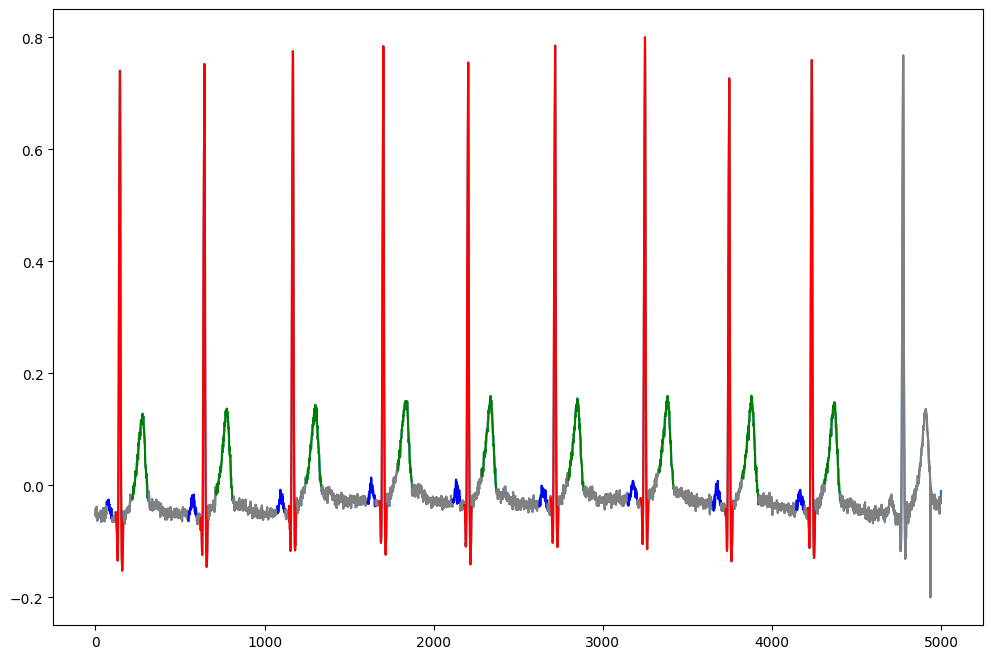

In [10]:
lead_idx = 10
fig, ax = plot_segmentations(data=data[:, lead_idx], labels=labels[:, lead_idx], preds=y_pred[:, lead_idx].squeeze())
fig.show()

In [11]:
ecg = nk.ecg_simulate(duration=10, heart_rate=60, sampling_rate=500)

In [12]:
y_pred = np.zeros_like(ecg)
for i in range(0, ecg.shape[0] - frame_keep + 1, frame_keep):
    y = model.predict(ecg[i:i+frame_size].reshape((1, frame_size, 1)), verbose=0).squeeze()
    y_pred[i:i+frame_keep] = y[:frame_keep].argmax(axis=1)
# END FOR  

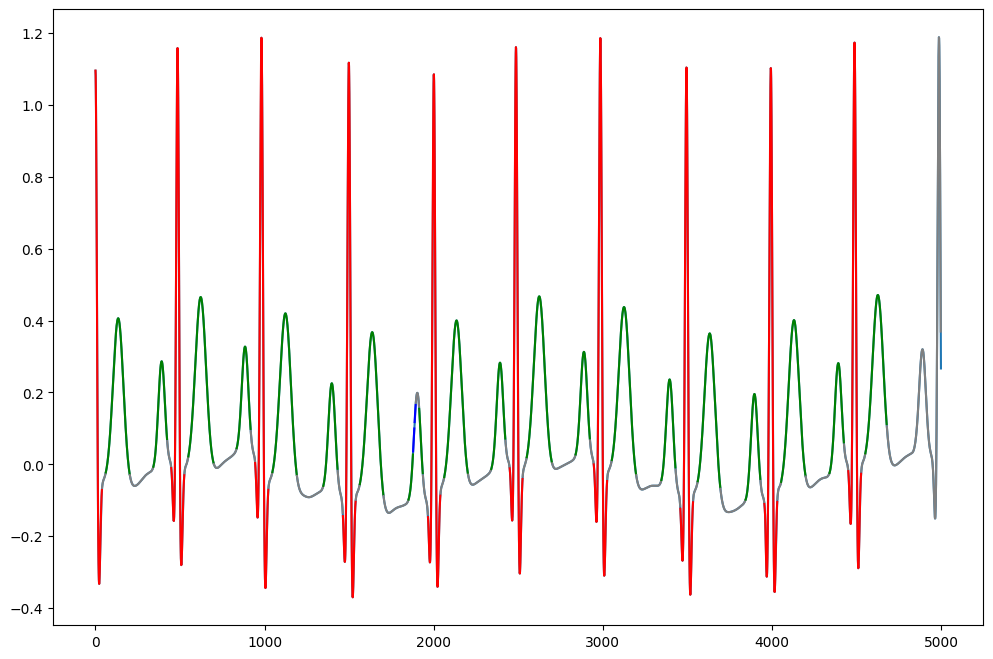

In [13]:
fig, ax = plot_segmentations(data=ecg, labels=None, preds=y_pred.squeeze())
fig.show()

* Use LUDB, QT, and Synthetic to train 
* Need to resample to 500 Hz (use all leads)
* Apply augmentations: inject noise, artifacts
* Apply filter, baseline wander removal, and normalize signal 

In [14]:
rst = syn_nsr(
    leads=12, 
    signal_frequency=1000, 
    rate=120,
    preset='SR',
    universal_noise_multiplier=0.8,
    impedance=1,
    p_multiplier=0.9,
    t_multiplier=0.8
)
data = 300*rst[1].transpose()[:5000, :]

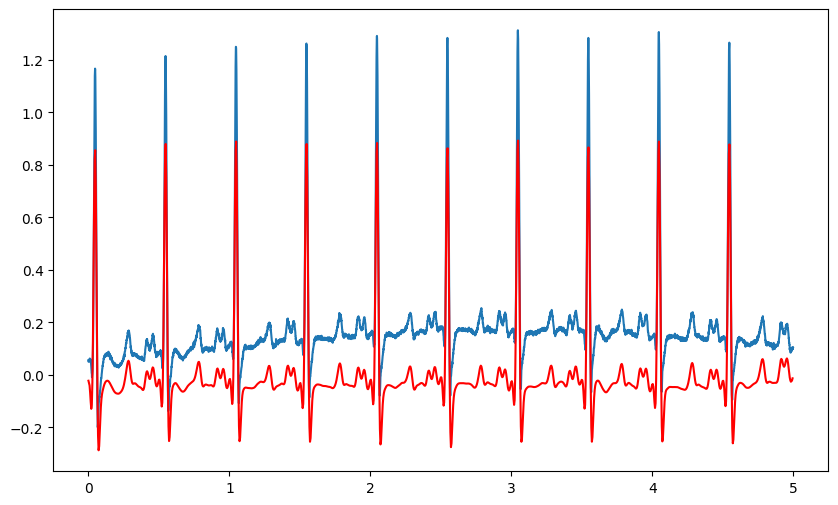

In [16]:
d1 = data[:, 0].squeeze()
d2 = nk.signal_filter(signal=d1, sampling_rate=1000, lowcut=0.5, highcut=30, method="butterworth", order=3)
d3 = nk.signal_resample(d2, sampling_rate=1000, desired_sampling_rate=250, method="FFT")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
t1 = np.arange(d2.shape[0])/1000.0
t3 = np.arange(d3.shape[0])/250.0
ax.plot(t1, d1)
ax.plot(t3, d3, color='red')



In [54]:
y_pred = np.zeros_like(labels)
for lead_idx in range(data.shape[1]):
    for i in range(0, data.shape[0] - frame_keep + 1, frame_keep):
        y = model.predict(data[i:i+frame_size, lead_idx].reshape((1, frame_size, 1)), verbose=0).squeeze()
        y_pred[i:i+frame_keep, lead_idx] = y[:frame_keep].argmax(axis=1)
    # END FOR   
# END FOR

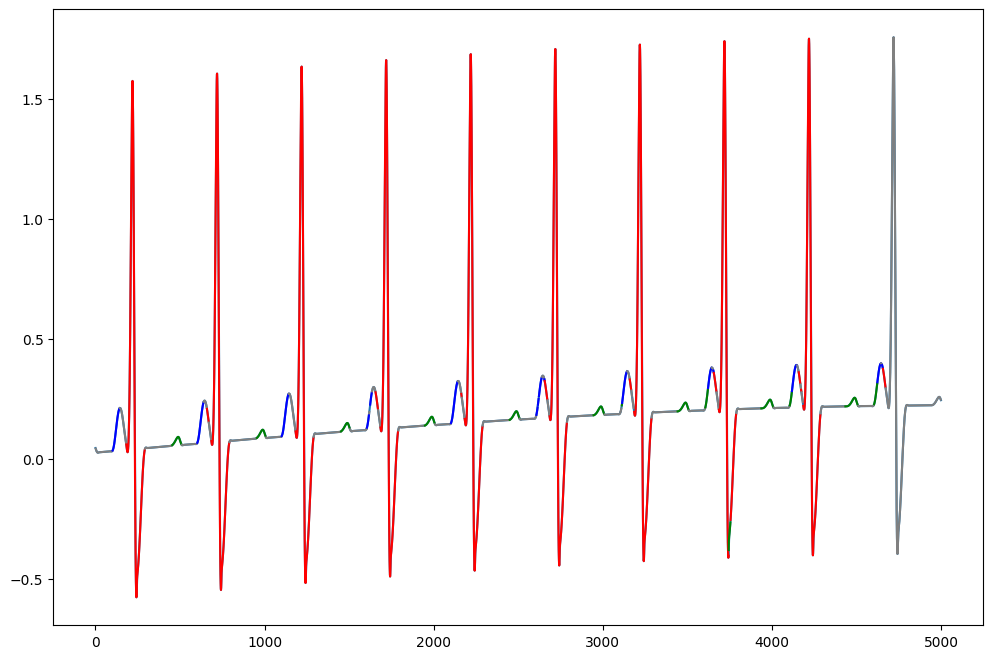

In [56]:
lead_idx = 9
fig, ax = plot_segmentations(data=data[:, lead_idx], labels=labels[:, lead_idx], preds=y_pred[:, lead_idx].squeeze())
fig.show()

In [17]:
ds = IcentiaDataset(
    ds_path=ds_path,
    task=HeartTask.beat,
    frame_size=500
)

In [19]:
train_ds, val_ds = ds.load_train_datasets(
    train_patients=0.2,
    val_patients=0.2,
    train_pt_samples=500,
    val_pt_samples=500,
    num_workers=8,
)

[02/17/23 09:57:04] INFO     Splitting patients into train and validation                            ]8;id=25288;file:///Users/adampage/Ambiq/model-zoo/heart-kit/heartkit/datasets/dataset.py\dataset.py]8;;\:]8;id=608611;file:///Users/adampage/Ambiq/model-zoo/heart-kit/heartkit/datasets/dataset.py#162\162]8;;\

                    INFO     Collecting 80000 validation samples                                     ]8;id=378630;file:///Users/adampage/Ambiq/model-zoo/heart-kit/heartkit/datasets/dataset.py\dataset.py]8;;\:]8;id=343558;file:///Users/adampage/Ambiq/model-zoo/heart-kit/heartkit/datasets/dataset.py#169\169]8;;\

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


[02/17/23 09:57:04] WARNING  WARNING:tensorflow:From                                             ]8;id=770360;file:///Users/adampage/Ambiq/model-zoo/heart-kit/.venv/lib/python3.10/site-packages/tensorflow/python/util/deprecation.py\deprecation.py]8;;\:]8;id=425492;file:///Users/adampage/Ambiq/model-zoo/heart-kit/.venv/lib/python3.10/site-packages/tensorflow/python/util/deprecation.py#350\350]8;;\
                             /Users/adampage/Ambiq/model-zoo/heart-kit/.venv/lib/python3.10/site                   
                             -packages/tensorflow/python/autograph/pyct/static_analysis/liveness                   
                             .py:83: Analyzer.lamba_check (from                                                    
                             tensorflow.python.autograph.pyct.static_analysis.liveness) is                         
                             deprecated and will be removed after 2023-09-23.                                      
                             Instructions for updating:                                                            
                             Lambda fuctions will be no more assumed to be used in the statement                   
                             where they are used, or at least in the same block.                                   
                             https://github.com/tensorflow/tensorflow/issues/56089                                 

: 

: 